# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import time
from dateutil.parser import parse
import datetime

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Cleaning
Above introduction, first change column names

- portfolio : id:offer_id
- profile : id:customer_id
- transcript : person:customer_id

In [3]:
portfolio.rename(columns={'id':'offer_id'},inplace=True)
profile.rename(columns={'id':'customer_id'}, inplace=True)
transcript.rename(columns={'person':'customer_id'}, inplace=True)

In [4]:
# offer
portfolio

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
profile.head()

,age,became_member_on,customer_id,gender,income
0,118,20170212,68be06ca386d4c31939f3a4f0e3dd783,None,NaN
1,55,20170715,0610b486422d4921ae7d2bf64640c50b,F,112000.0
2,118,20180712,38fe809add3b4fcf9315a9694bb96ff5,None,NaN
3,75,20170509,78afa995795e4d85b5d9ceeca43f5fef,F,100000.0
4,118,20170804,a03223e636434f42ac4c3df47e8bac43,None,NaN


In [6]:
# offerstation
transcript.head()

,customer_id,event,time,value
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,e2127556f4f64592b11af22de27a7932,offer received,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## portfolio EDA

In [7]:
# check data set
portfolio

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [8]:
# one hot code portfolio['channels']
for i in ['web', 'email', 'mobile', 'socia']:
    portfolio[i] = portfolio['channels'].apply(lambda x: 1 if i in x else 0)
    
portfolio

,channels,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,socia
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,0
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,0
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


## profile EDA

In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
customer_id         17000 non-null object
gender              14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [10]:
# check statistics
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


Let's caculate the gender proportion:

In [11]:
# gender of data sets
m = 100*profile.gender.value_counts()[0]/profile.gender.value_counts().sum()
f = 100*profile.gender.value_counts()[1]/profile.gender.value_counts().sum()
o = 100*profile.gender.value_counts()[2]/profile.gender.value_counts().sum()

print('M: ',m,'%', ' ', profile.gender.value_counts()[0],'rows')
print('F: ',f,'%', ' ', profile.gender.value_counts()[1],'rows')
print('O: ',o,'%', ' ', profile.gender.value_counts()[2],'rows')
print('NaN : {} %   {} rows'.format(100*abs(profile.gender.value_counts().sum() - len(profile))/len(profile),
                                    len(profile[profile.gender.isna()])))

M:  57.2276559865 %   8484 rows
F:  41.3423271501 %   6129 rows
O:  1.43001686341 %   212 rows
NaN : 12.794117647058824 %   2175 rows


We can see the gender is not clear, with M,F,O,and NaN. So it's better to drop O and NaN.

In [13]:
# check 'O'
profile.query("gender == 'O'")

,age,became_member_on,customer_id,gender,income
31,53,20170916,d1ede868e29245ea91818a903fec04c6,O,52000.0
273,60,20180216,d0be9ff460964c3398a33ad9b2829f3a,O,94000.0
383,49,20171207,0d0a9ca9281248a8a35806c9ae68f872,O,42000.0
513,63,20150920,01f46a5191424005af436cdf48a5da7c,O,89000.0
576,73,20180316,644ac06dc9b34a5bbd237a465cf47571,O,88000.0
851,48,20160729,338c28f32c5944a99a0529be26d145dd,O,80000.0
889,32,20161223,0d96a963d3e94044aa7934276db005e4,O,54000.0
895,59,20170805,494a99f508f74ad0ae047c68bf837791,O,73000.0
979,74,20150910,2ddc7d63c32d4606a7a45e3e70439b44,O,61000.0
981,55,20170504,acde74ee0f4d418e8fd5bf4f4da8f56c,O,76000.0


### To do list:

- id: change to customer_id
- became_member_on : type---int change datetime into month since become a member
- delate gender O & NaN
- groupby different age ranks
- check proportion of different age groups
- drop rows with NaN
- count number of members in different income_ranks
- visualiza
- count number of M & F

In [14]:
# drop rows where gender == O
profile = profile[-profile.gender.isin(['O'])]

In [17]:
# group into different age ranks
a = [x for x in np.arange(10,30)]
b = [x for x in np.arange(30,50)]
c = [x for x in np.arange(50,70)]
d = [x for x in np.arange(70,90)]
e = [x for x in np.arange(90,120)]
years = pd.DataFrame(profile.age)
yy = []
for i in years.index:
    y = years.loc[i]['age']
#     print(y)
    if y in a:
        yy.append('10s_20s')
    elif y in b:
        yy.append('30s_40s')
    elif y in c:
        yy.append('50s_60s')
    elif y in d:
        yy.append('70s_80s')
    elif y in e:
        yy.append('90s_100s')
profile['years'] = yy

In [18]:
# Proportion of different age groups
print("Proportion of different age groups : ")
print(profile['years'].value_counts()/len(profile))

Proportion of different age groups : 
50s_60s     0.383429
30s_40s     0.224684
70s_80s     0.153562
90s_100s    0.145521
10s_20s     0.092804
Name: years, dtype: float64


In [19]:
profile.income.describe()

count     14613.000000
mean      65435.707931
std       21633.524110
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [20]:
# the all age of customers with None income is 118, and their gender is also None
# they make a small proportion and decided to delate them
print(profile[profile.income.isnull()]['age'].describe())
print(profile[profile.income.isnull()]['gender'].value_counts())

count    2175.0
mean      118.0
std         0.0
min       118.0
25%       118.0
50%       118.0
75%       118.0
max       118.0
Name: age, dtype: float64
Series([], Name: gender, dtype: int64)


In [21]:
# drop NaN
profile = profile.dropna(how='any',axis=0)

In [24]:
# check
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14613 entries, 1 to 16999
Data columns (total 6 columns):
age                 14613 non-null int64
became_member_on    14613 non-null int64
customer_id         14613 non-null object
gender              14613 non-null object
income              14613 non-null float64
years               14613 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 799.1+ KB


In [25]:
# caculate the duration since became a member
bmo = profile[['became_member_on']]
become_days = []
become_years = []
for i in bmo.index:
    dt = str(bmo.loc[i]['became_member_on'])
    y = int(dt[:4])
    m = int(dt[-4:-2])
    d = int(dt[-2:])
    d1 = datetime.datetime(y,m,d)
    d2 = datetime.datetime(2019,6,15)
    interval = d2 - d1
    
    become_days.append(interval.days)
    become_years.append(y)

profile['became_days'] = become_days
profile['became_onyear'] = become_years

In [32]:
profile.head()

,age,became_member_on,customer_id,gender,income,years,became_days,became_onyear,income_rank
1,55,20170715,0610b486422d4921ae7d2bf64640c50b,F,112000.0,50s_60s,700,2017,110~130k
3,75,20170509,78afa995795e4d85b5d9ceeca43f5fef,F,100000.0,70s_80s,767,2017,90~110k
5,68,20180426,e2127556f4f64592b11af22de27a7932,M,70000.0,50s_60s,415,2018,50~70k
8,65,20180209,389bc3fa690240e798340f5a15918d5c,M,53000.0,50s_60s,491,2018,50~70k
12,58,20171111,2eeac8d8feae4a8cad5a6af0499a211d,M,51000.0,50s_60s,581,2017,50~70k


Check the number and describe of customers in each income ranks.

In [30]:
count_income

,income_rank,counts
0,110~130k,460
1,30~50k,3982
2,50~70k,4920
3,70~90k,3534
4,90~110k,1717


In [31]:
profile.income.describe()

count     14613.000000
mean      65435.707931
std       21633.524110
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [28]:
# mark income into different ranks 
income_rank = []

for i in profile.income:
    if i <= 50000:       
        income_rank.append('30~50k')
    elif i <= 70000:
        income_rank.append('50~70k')
    elif i <= 90000:
        income_rank.append('70~90k')
    elif i<= 110000:
        income_rank.append('90~110k')
    else:
        income_rank.append('110~130k')
    
profile['income_rank'] = income_rank

Count number of members in different income_ranks. And then visualiza the proportion of members income_ranks

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


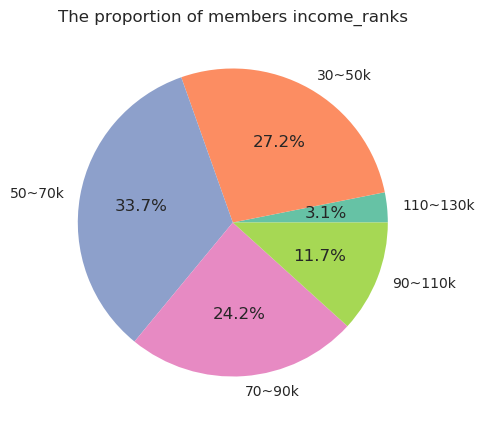

In [33]:
count_income = profile.groupby(['income_rank']).count().reset_index()
count_income = count_income[['income_rank','customer_id']]
count_income.columns = ['income_rank','counts']

plt.style.use('default')
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set2')

fig = plt.figure(figsize=(5,5))
ax = plt.title('The proportion of members income_ranks')
ax = fig.add_subplot(1, 1, 1)
ax.pie(count_income.counts, labels=count_income.income_rank, autopct="%1.1f%%")
plt.show()

The population with the income of 50~70k accounts for the largest proportion, about 33.7%, and followed by 30~50k about 27.2%, then70^90k about 24.2%. Starbucks is even loved by some senior customers, it is a very rare thing.

Let's count the number of new members every year.

In [34]:
count_men = profile.groupby(['became_onyear','gender']).count().reset_index()
count_men = count_men[['became_onyear','gender','customer_id']]
count_men.columns = ['became_onyear','gender','counts']

The number of customers become new members in every years.

In [35]:
count_men

,became_onyear,gender,counts
0,2013,F,74
1,2013,M,197
2,2014,F,138
3,2014,M,520
4,2015,F,663
5,2015,M,905
6,2016,F,1509
7,2016,M,1483
8,2017,F,2443
9,2017,M,3067


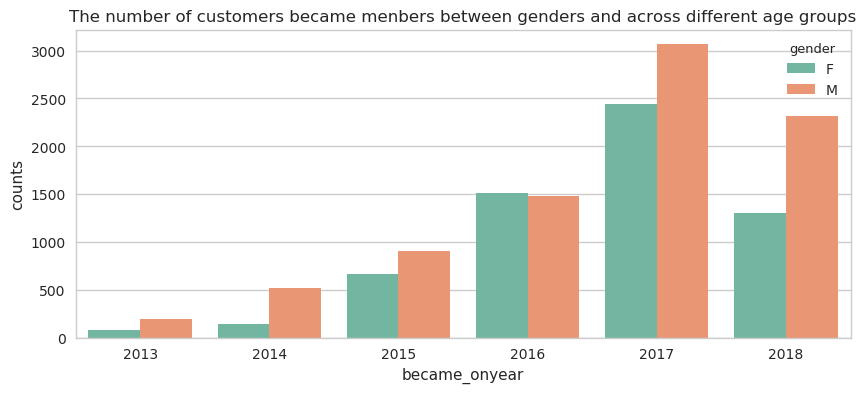

In [36]:
# The number of customers became menbers between genders and across different age groups every year
plt.figure(figsize=(10, 4))
plt.title('The number of customers became menbers between genders and across different age groups')
sns.barplot(x='became_onyear', y='counts', hue='gender',data=count_men);

We can see that there are many new users joining each year from 2013 to 2018, and the number of new users increasing by 2017. Compared with 2018, the increase in 2018 is not more than 17 years. Maybe the data of 18 years is incomplete, or some other reasons, let's continue to look down.

In [37]:
# count the number of customers between genders and across different age groups
counts = profile.groupby(['years','gender']).count().reset_index()
procounts = counts[['years', 'gender','customer_id']]
procounts.columns = ['years', 'gender','counts']

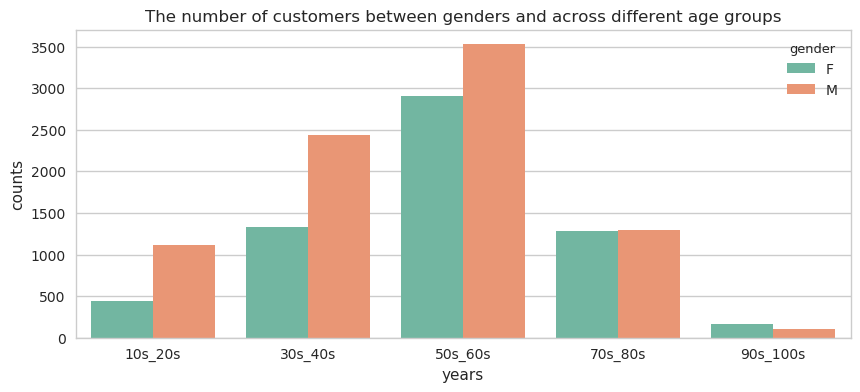

In [38]:
# The number of customers between genders and across different age groups
plt.figure(figsize=(10, 4))
plt.title('The number of customers between genders and across different age groups')
sns.barplot(x='years', y='counts', hue='gender',data=procounts);

In terms of age and gender distribution, there are more women than men in the user group, and most customers in the 1950s and 1960s. That's also a surprise to me. I thought that customers in the 20s and 40s would be higher, that is, higher than I expected, perhaps because Starbucks has been around for many years. Or its atmosphere and so on are widely loved. So whether it's the 50's, 60's or younger customers, I guess it's not wrong to assume that working people and students are the main groups.

In [39]:
print("Number of man and woman : ")
print(profile.gender.value_counts())

Number of man and woman : 
M    8484
F    6129
Name: gender, dtype: int64


In [40]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14613 entries, 1 to 16999
Data columns (total 9 columns):
age                 14613 non-null int64
became_member_on    14613 non-null int64
customer_id         14613 non-null object
gender              14613 non-null object
income              14613 non-null float64
years               14613 non-null object
became_days         14613 non-null int64
became_onyear       14613 non-null int64
income_rank         14613 non-null object
dtypes: float64(1), int64(4), object(4)
memory usage: 1.7+ MB


## transcript EDA

### To do list :

- split value into 2 parts (offer_id, types)
- rename columns
- create new dataframe trans_event to describe of events in transcript
- time : value counts
- one hot coding event
- Calculate the proportion of transaction and offer events
- Create new DataFrame pro_tran with the customer_id in profile only
- Calculate the proportion of removed transcript
- Calculate the proportion of removed customer_id
- Create the new dataset pro_tran (merge new_transcript and profile)
- visualization: Offer completion vs.income_rank totally, offer_id compeletion, and years, gender, year

In [82]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
customer_id    306534 non-null object
event          306534 non-null object
time           306534 non-null int64
value          306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [84]:
# split value into 2 parts 
transcript['types'] = transcript['value'].apply(lambda x: list(x.keys())[0])
transcript['offer_id'] = transcript['value'].apply(lambda x: list(x.values())[0])

In [45]:
print(' transcript:',transcript.event.value_counts()[0]/len(transcript),'\n',
      'offer received:',transcript.event.value_counts()[1]/len(transcript),'\n',
      'offer viewed:',transcript.event.value_counts()[2]/len(transcript),'\n',
      'offer completed:',transcript.event.value_counts()[3]/len(transcript))

print(transcript.event.value_counts())

 transcript: 0.453303711823 
 offer received: 0.248836996875 
 offer viewed: 0.188315162429 
 offer completed: 0.109544128873
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64


In [86]:
# 'offer received', 'offer viewed', 'transaction', 'offer completed' : yes--1, no--0
for i in ['offer received', 'offer viewed', 'transaction', 'offer completed']:
    transcript[i] = transcript.event.apply(lambda x: 1 if i in x else 0)

In [91]:
transcript.head()

,customer_id,event,time,value,types,offer_id,offer_received,offer_viewed,transaction,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},offer id,2906b810c7d4411798c6938adc9daaa5,1,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},offer id,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,0


In [90]:
transcript.columns

Index(['customer_id', 'event', 'time', 'value', 'types', 'offer_id',
       'offer_received', 'offer_viewed', 'transaction', 'offer_completed'],
      dtype='object')

In [89]:
transcript.columns = ['customer_id', 'event', 'time', 'value', 'types', 'offer_id',
                      'offer_received', 'offer_viewed', 'transaction', 'offer_completed']

In [93]:
transcript.sample(5)

,customer_id,event,time,value,types,offer_id,offer_received,offer_viewed,transaction,offer_completed
243756,d1d3790e548e444fa3c8321bd38c4cd7,offer viewed,570,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer id,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0
5204,871459b0d34542dfb159773a95d5adb9,offer received,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},offer id,2906b810c7d4411798c6938adc9daaa5,1,0,0,0
107209,04e5255c9e754c66b83c06ec70f62203,transaction,312,{'amount': 9.04},amount,9.04,0,0,1,0
175913,01e09d713abe4a36a70a33fe4b40534e,transaction,426,{'amount': 19.58},amount,19.58,0,0,1,0
171720,fae649ff726b4af68d0805de45181fb3,offer viewed,420,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0


In [92]:
# check 
transcript.columns

Index(['customer_id', 'event', 'time', 'value', 'types', 'offer_id',
       'offer_received', 'offer_viewed', 'transaction', 'offer_completed'],
      dtype='object')

In [94]:
new_transcript = transcript[['customer_id', 'event', 'time', 'types', 'offer_id',
                             'offer_received', 'offer_viewed', 'transaction', 'offer_completed']]

In [95]:
# The describe of events in transcript
trans_event = pd.DataFrame(transcript.event.value_counts()).reset_index()
trans_event.columns = ['events','counts']
trans_event


,events,counts
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


In [96]:
new_transcript.head()

,customer_id,event,time,types,offer_id,offer_received,offer_viewed,transaction,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5,1,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,0


In [97]:
print('The proportion of transcation is {}%.'.format(100*trans_event.loc[0]['counts']/trans_event['counts'].sum()))
print('Thr proportion of offer events is {}%'.format(100*trans_event.loc[1:]['counts'].sum()/trans_event['counts'].sum()))

The proportion of transcation is 45.33037118231583%.
Thr proportion of offer events is 54.66962881768417%


In [99]:
profile.head()

,age,became_member_on,customer_id,gender,income,years,became_days,became_onyear,income_rank
1,55,20170715,0610b486422d4921ae7d2bf64640c50b,F,112000.0,50s_60s,700,2017,110~130k
3,75,20170509,78afa995795e4d85b5d9ceeca43f5fef,F,100000.0,70s_80s,767,2017,90~110k
5,68,20180426,e2127556f4f64592b11af22de27a7932,M,70000.0,50s_60s,415,2018,50~70k
8,65,20180209,389bc3fa690240e798340f5a15918d5c,M,53000.0,50s_60s,491,2018,50~70k
12,58,20171111,2eeac8d8feae4a8cad5a6af0499a211d,M,51000.0,50s_60s,581,2017,50~70k


In [98]:
new_transcript.head()

,customer_id,event,time,types,offer_id,offer_received,offer_viewed,transaction,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5,1,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,0


In [100]:
# Create the pro_tran
pro_tran = pd.merge(new_transcript,profile, how='inner',on='customer_id')

print('The proportion of removed customer_id is {}%.'.format(
    100*abs(profile.customer_id.nunique()-transcript.customer_id.nunique())/transcript.customer_id.nunique()))
print('The proportion of removed transcript is {}%.'.format(
    100*(new_transcript.shape[0]- pro_tran.shape[0])/new_transcript.shape[0]))

pro_tran.info()

The proportion of removed customer_id is 14.041176470588235%.
The proportion of removed transcript is 12.312826635870735%.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 268791 entries, 0 to 268790
Data columns (total 17 columns):
customer_id         268791 non-null object
event               268791 non-null object
time                268791 non-null int64
types               268791 non-null object
offer_id            268791 non-null object
offer_received      268791 non-null int64
offer_viewed        268791 non-null int64
transaction         268791 non-null int64
offer_completed     268791 non-null int64
age                 268791 non-null int64
became_member_on    268791 non-null int64
gender              268791 non-null object
income              268791 non-null float64
years               268791 non-null object
became_days         268791 non-null int64
became_onyear       268791 non-null int64
income_rank         268791 non-null object
dtypes: float64(1), int64(9), object(7)
mem

In [101]:
pro_tran.head()

,customer_id,event,time,types,offer_id,offer_received,offer_viewed,transaction,offer_completed,age,became_member_on,gender,income,years,became_days,became_onyear,income_rank
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,75,20170509,F,100000.0,70s_80s,767,2017,90~110k
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,75,20170509,F,100000.0,70s_80s,767,2017,90~110k
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,amount,19.89,0,0,1,0,75,20170509,F,100000.0,70s_80s,767,2017,90~110k
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,0,1,75,20170509,F,100000.0,70s_80s,767,2017,90~110k
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,amount,17.78,0,0,1,0,75,20170509,F,100000.0,70s_80s,767,2017,90~110k


- Caculate the proportion of offer_completed 

In [102]:
print('The number of offer_completed: 0---Uncompleted, 1---completed')
pro_tran.offer_completed.value_counts()

The number of offer_completed: 0---Uncompleted, 1---completed


0    236848
1     31943
Name: offer_completed, dtype: int64

In [103]:
pro_tran.groupby(['offer_completed','gender']).count()

customer_id   event    time   types  offer_id  \
offer_completed gender                                                  
0               F             97624   97624   97624   97624     97624   
                M            139224  139224  139224  139224    139224   
1               F             15477   15477   15477   15477     15477   
                M             16466   16466   16466   16466     16466   

                        offer_received  offer_viewed  transaction     age  \
offer_completed gender                                                      
0               F                97624         97624        97624   97624   
                M               139224        139224       139224  139224   
1               F                15477         15477        15477   15477   
                M                16466         16466        16466   16466   

                        became_member_on  income   years  became_days  \
offer_completed gender                                                  
0               F                  97624   97624   97624        97624   
                M                 139224  139224  139224       139224   
1               F                  15477   15477   15477        15477   
                M                  16466   16466   16466        16466   

                        became_onyear  income_rank  
offer_completed gender                              
0               F               97624        97624  
                M              139224       139224  
1               F               15477        15477  
                M               16466        16466

In list offer_ids, there are all offer_id, and then use the function vasl_gdf(),and get_offid_df(),we can check completion about income rank, became on year, years(year grade), and gender with groupping by cols,cols1,cols2,cols3.

In [106]:
offer_ids = ['fafdcd668e3743c1bb461111dcafc2a4','2298d6c36e964ae4a3e7e9706d1fb8c2','f19421c1d4aa40978ebb69ca19b0e20d',
             '4d5c57ea9a6940dd891ad53e9dbe8da0','ae264e3637204a6fb9bb56bc8210ddfd','9b98b8c7a33c4b65b9aebfe6a799e6d9',
             '2906b810c7d4411798c6938adc9daaa5','5a8bc65990b245e5a138643cd4eb9837','0b1e1539f2cc45b7b9fa7c272da2e1d7',
             '3f207df678b143eea3cee63160fa8bed ']

cols=['offer_completed','income_rank']
cols1=['offer_completed','became_onyear']
cols2=['offer_completed','years']
cols3=['offer_completed','gender']

def vasl_gdf(cols,df):
    """
    input cols:list of columns
    output 
    """
    gdf = pd.DataFrame(df.groupby(cols)['customer_id'].count())
    gdf = gdf.reset_index().rename(columns={'customer_id':'numbers'})
    ax = plt.title('Offer completion vs. {}'.format(cols[1]))
    ax = sns.barplot(x=gdf[cols[0]],y=gdf.numbers,hue=gdf[cols[1]],data=gdf);
    return gdf,ax


In [107]:
def get_offid_df(n):
    """
    input:
        n (index of offer id in offer_ids [0~9])
    output:
        offidx (offer_id) print it
        offid_df a dataframe for function vasl_gdf to visualization
    """
    offidx = offer_ids[n]
    offid_df = pro_tran[pro_tran.offer_id == offidx]
    print('Offer id : {}'.format(offidx))
    return offid_df

In [108]:
pro_tran.head()

,customer_id,event,time,types,offer_id,offer_received,offer_viewed,transaction,offer_completed,age,became_member_on,gender,income,years,became_days,became_onyear,income_rank
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,75,20170509,F,100000.0,70s_80s,767,2017,90~110k
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,75,20170509,F,100000.0,70s_80s,767,2017,90~110k
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,amount,19.89,0,0,1,0,75,20170509,F,100000.0,70s_80s,767,2017,90~110k
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,0,1,75,20170509,F,100000.0,70s_80s,767,2017,90~110k
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,amount,17.78,0,0,1,0,75,20170509,F,100000.0,70s_80s,767,2017,90~110k


In [80]:
portfolio

,channels,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,socia
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,0
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,0
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


In [130]:
pro_tran.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268791 entries, 0 to 268790
Data columns (total 17 columns):
customer_id         268791 non-null object
event               268791 non-null object
time                268791 non-null int64
types               268791 non-null object
offer_id            268791 non-null object
offer_received      268791 non-null int64
offer_viewed        268791 non-null int64
transaction         268791 non-null int64
offer_completed     268791 non-null int64
age                 268791 non-null int64
became_member_on    268791 non-null int64
gender              268791 non-null object
income              268791 non-null float64
years               268791 non-null object
became_days         268791 non-null int64
became_onyear       268791 non-null int64
income_rank         268791 non-null object
dtypes: float64(1), int64(9), object(7)
memory usage: 36.9+ MB


In [128]:
proportra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146615 entries, 0 to 146614
Data columns (total 26 columns):
customer_id         146615 non-null object
event               146615 non-null object
time                146615 non-null int64
types               146615 non-null object
offer_id            146615 non-null object
offer_received      146615 non-null int64
offer_viewed        146615 non-null int64
transaction         146615 non-null int64
offer_completed     146615 non-null int64
age                 146615 non-null int64
became_member_on    146615 non-null int64
gender              146615 non-null object
income              146615 non-null float64
years               146615 non-null object
became_days         146615 non-null int64
became_onyear       146615 non-null int64
income_rank         146615 non-null object
channels            146615 non-null object
difficulty          146615 non-null int64
duration            146615 non-null int64
offer_type          146615 non-null obj

### Overall status of completion 

Then take a look at the completion of each offer.

(    offer_completed                          offer_id  numbers
 0                 0  0b1e1539f2cc45b7b9fa7c272da2e1d7     8788
 1                 0  2298d6c36e964ae4a3e7e9706d1fb8c2    12852
 2                 0  2906b810c7d4411798c6938adc9daaa5     9938
 3                 0  3f207df678b143eea3cee63160fa8bed     9978
 4                 0  4d5c57ea9a6940dd891ad53e9dbe8da0    12779
 5                 0  5a8bc65990b245e5a138643cd4eb9837    12326
 6                 0  9b98b8c7a33c4b65b9aebfe6a799e6d9    10007
 7                 0  ae264e3637204a6fb9bb56bc8210ddfd    12408
 8                 0  f19421c1d4aa40978ebb69ca19b0e20d    12713
 9                 0  fafdcd668e3743c1bb461111dcafc2a4    12883
 10                1  0b1e1539f2cc45b7b9fa7c272da2e1d7     3323
 11                1  2298d6c36e964ae4a3e7e9706d1fb8c2     4819
 12                1  2906b810c7d4411798c6938adc9daaa5     3851
 13                1  4d5c57ea9a6940dd891ad53e9dbe8da0     3265
 14                1  9b98b8c7a33c4b65b9

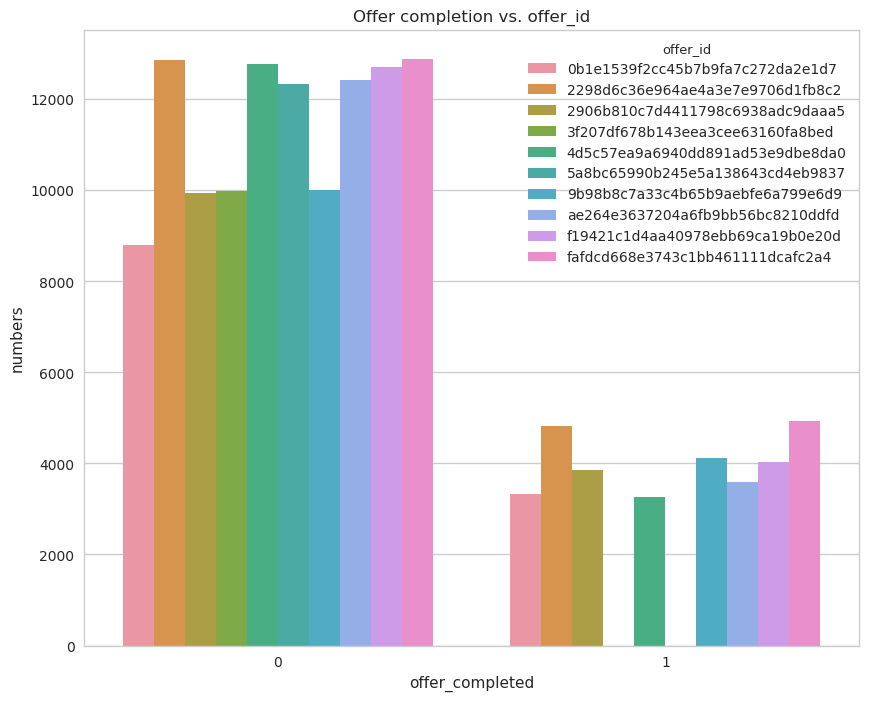

In [109]:
# Create new dataframe of offer_id compeltion 
# Visulization weather offer_id were compeleted or not
proportra = pd.merge(pro_tran,portfolio,how='inner',on='offer_id')
cols=['offer_completed','offer_id']

plt.figure(figsize=(10,8))
vasl_gdf(cols,proportra)

0 represents not completed, 1 represents completed, well, for relatively more completed, there are still some quotations that have never been completed.

(   offer_completed income_rank  numbers
 0                0    110~130k     6296
 1                0      30~50k    69988
 2                0      50~70k    83606
 3                0      70~90k    52896
 4                0     90~110k    24062
 5                1    110~130k     1303
 6                1      30~50k     6459
 7                1      50~70k    10401
 8                1      70~90k     9125
 9                1     90~110k     4655,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f733beeab00>)

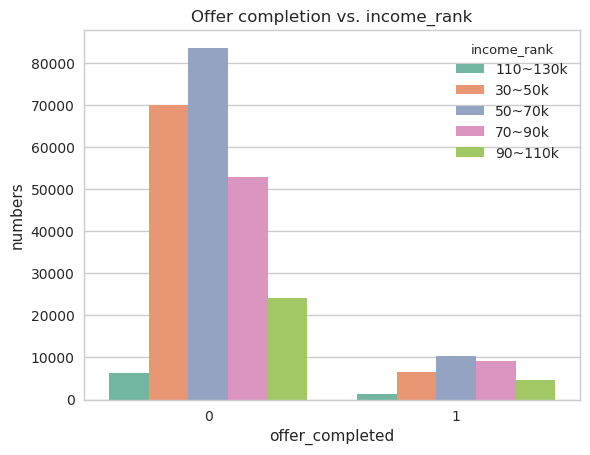

In [110]:
# Offer completion vs.income_rank totally
cols=['offer_completed','income_rank']
vasl_gdf(cols,pro_tran)

(    offer_completed  became_onyear  numbers
 0                 0           2013     5502
 1                 0           2014    13350
 2                 0           2015    29535
 3                 0           2016    54404
 4                 0           2017    86617
 5                 0           2018    47440
 6                 1           2013      556
 7                 1           2014     1315
 8                 1           2015     4222
 9                 1           2016     8831
 10                1           2017    11935
 11                1           2018     5084,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f733bef48d0>)

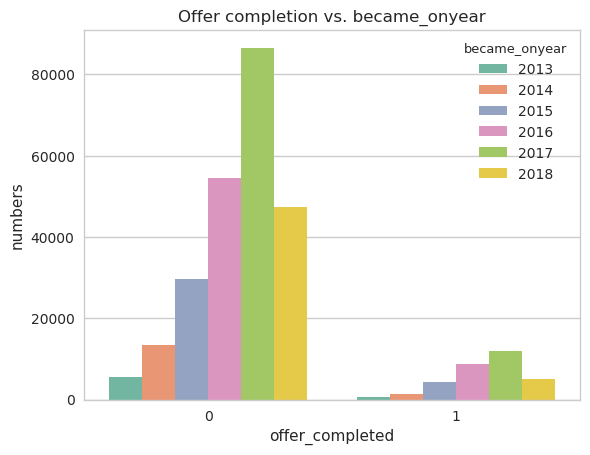

In [111]:
# Offer completion vs.became_onyear totally
cols1=['offer_completed','became_onyear']
vasl_gdf(cols1,pro_tran)


The number of users who become members in 2017 is the largest, perhaps because the number of members in 2017 is the highest in recent years.

(   offer_completed     years  numbers
 0                0   10s_20s    27948
 1                0   30s_40s    63793
 2                0   50s_60s   100943
 3                0   70s_80s    40056
 4                0  90s_100s     4108
 5                1   10s_20s     2683
 6                1   30s_40s     7714
 7                1   50s_60s    14952
 8                1   70s_80s     5972
 9                1  90s_100s      622,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f733be03c50>)

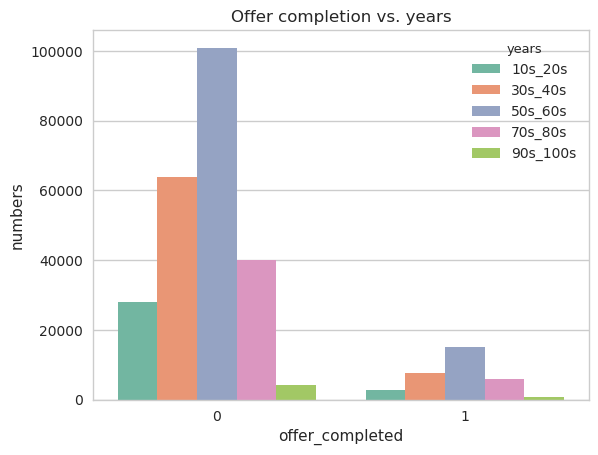

In [112]:
# Offer completion vs. years totally
cols2=['offer_completed','years']
vasl_gdf(cols2,pro_tran)


Because of their own 50, 60's membership is the highest reason, they are also the highest number of complete offer.


User completion is better when revenue is between 50K and 90K

(   offer_completed gender  numbers
 0                0      F    97624
 1                0      M   139224
 2                1      F    15477
 3                1      M    16466,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f733be18390>)

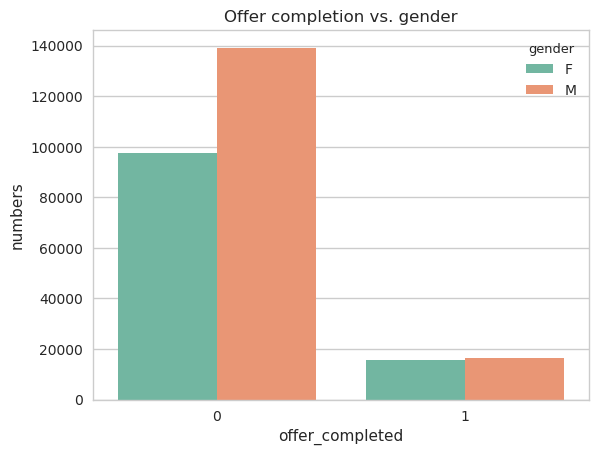

In [113]:
# Offer completion vs.gender totally
cols3=['offer_completed','gender']
vasl_gdf(cols3,pro_tran)

With function vasl_gdf(cols,df),def get_offid_df(n) we can check the situation of each offerid, for example let's see 
n=0, the first offer id in list. And you'd better check anyone you want, with the index(0~9) only.

offer_id:

fafdcd668e3743c1bb461111dcafc2a4

The number of offer_completed vs. income_rank:

Offer id : fafdcd668e3743c1bb461111dcafc2a4


(   offer_completed income_rank  numbers
 0                0    110~130k      399
 1                0      30~50k     3470
 2                0      50~70k     4414
 3                0      70~90k     3143
 4                0     90~110k     1457
 5                1    110~130k      182
 6                1      30~50k     1170
 7                1      50~70k     1614
 8                1      70~90k     1340
 9                1     90~110k      631,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f733bdeeba8>)

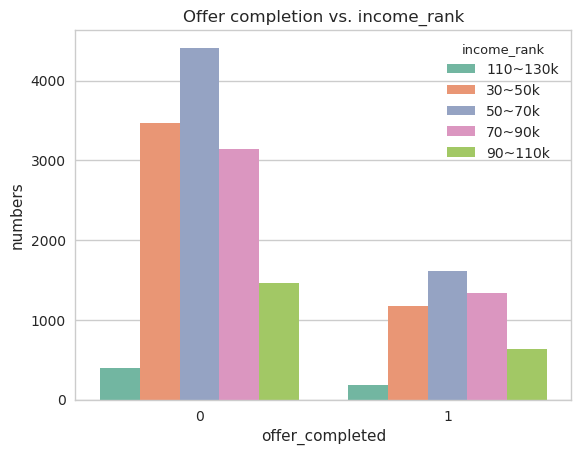

In [114]:
offid_df = get_offid_df(0)
vasl_gdf(cols,offid_df)

offer_completed  became_onyear:

Offer id : fafdcd668e3743c1bb461111dcafc2a4


(    offer_completed  became_onyear  numbers
 0                 0           2013      231
 1                 0           2014      627
 2                 0           2015     1394
 3                 0           2016     2627
 4                 0           2017     4713
 5                 0           2018     3291
 6                 1           2013      113
 7                 1           2014      280
 8                 1           2015      682
 9                 1           2016     1292
 10                1           2017     1746
 11                1           2018      824,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f733be2b860>)

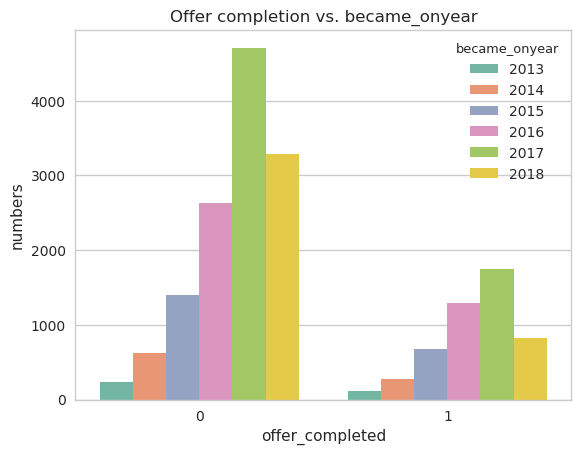

In [115]:
offid_df = get_offid_df(0)
vasl_gdf(cols1,offid_df)

Since 2013, the number of new members, both male and female, has been increasing. In 2008, the number of new members is relatively small. I think the data of 2018 is incomplete.

Offer id : fafdcd668e3743c1bb461111dcafc2a4


(   offer_completed     years  numbers
 0                0   10s_20s     1364
 1                0   30s_40s     3303
 2                0   50s_60s     5767
 3                0   70s_80s     2209
 4                0  90s_100s      240
 5                1   10s_20s      452
 6                1   30s_40s     1222
 7                1   50s_60s     2292
 8                1   70s_80s      874
 9                1  90s_100s       97,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f733bdb5b70>)

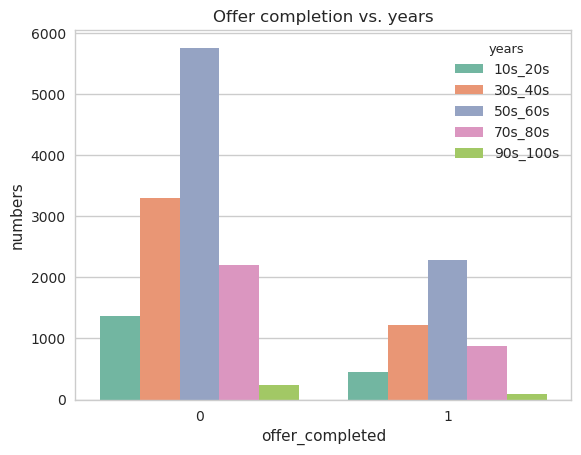

In [116]:
offid_df = get_offid_df(0)
vasl_gdf(cols2,offid_df)

From the portfolio the type of this offer id is discount, it is completed by age in 50~60.

Offer id : fafdcd668e3743c1bb461111dcafc2a4


(   offer_completed gender  numbers
 0                0      F     5304
 1                0      M     7579
 2                1      F     2216
 3                1      M     2721,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f733bd11518>)

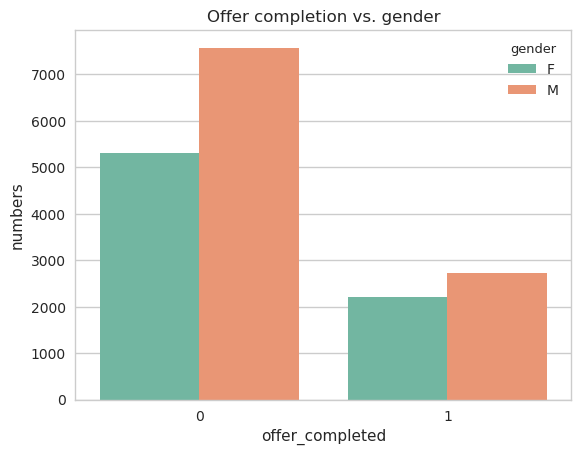

In [117]:
offid_df = get_offid_df(0)
vasl_gdf(cols3,offid_df)

Offer id : 2298d6c36e964ae4a3e7e9706d1fb8c2


(   offer_completed income_rank  numbers
 0                0    110~130k      353
 1                0      30~50k     3434
 2                0      50~70k     4422
 3                0      70~90k     3112
 4                0     90~110k     1531
 5                1    110~130k      148
 6                1      30~50k     1160
 7                1      50~70k     1613
 8                1      70~90k     1267
 9                1     90~110k      631,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f733bc3eeb8>)

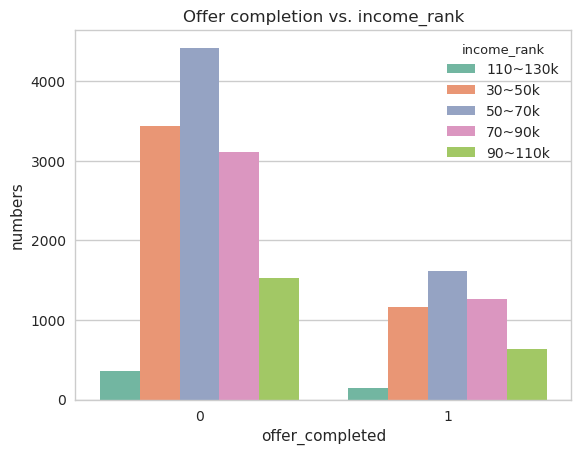

In [118]:
# Offer id : 2298d6c36e964ae4a3e7e9706d1fb8c2
offid_df = get_offid_df(1)
vasl_gdf(cols,offid_df)

Offer id : 2298d6c36e964ae4a3e7e9706d1fb8c2


(    offer_completed  became_onyear  numbers
 0                 0           2013      232
 1                 0           2014      570
 2                 0           2015     1245
 3                 0           2016     2628
 4                 0           2017     4924
 5                 0           2018     3253
 6                 1           2013      105
 7                 1           2014      253
 8                 1           2015      587
 9                 1           2016     1267
 10                1           2017     1799
 11                1           2018      808,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f733bc1d5c0>)

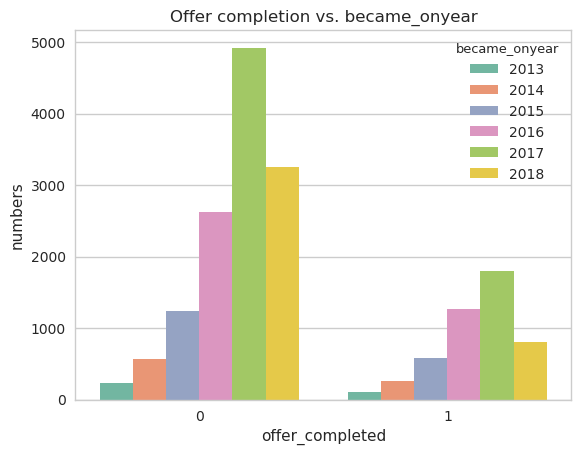

In [119]:
offid_df = get_offid_df(1)
vasl_gdf(cols1,offid_df)

(    offer_completed  became_onyear  numbers
 0                 0           2013     5502
 1                 0           2014    13350
 2                 0           2015    29535
 3                 0           2016    54404
 4                 0           2017    86617
 5                 0           2018    47440
 6                 1           2013      556
 7                 1           2014     1315
 8                 1           2015     4222
 9                 1           2016     8831
 10                1           2017    11935
 11                1           2018     5084,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f733ba08be0>)

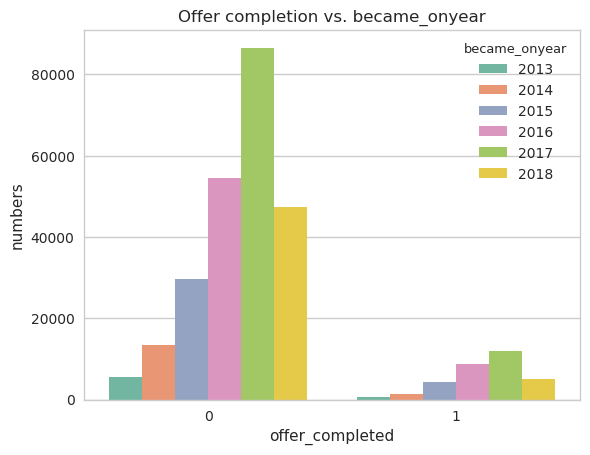

In [133]:
# overall
cols=['offer_completed','became_onyear']
vasl_gdf(cols,pro_tran)

(   offer_completed     years  numbers
 0                0   10s_20s    27948
 1                0   30s_40s    63793
 2                0   50s_60s   100943
 3                0   70s_80s    40056
 4                0  90s_100s     4108
 5                1   10s_20s     2683
 6                1   30s_40s     7714
 7                1   50s_60s    14952
 8                1   70s_80s     5972
 9                1  90s_100s      622,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f733b98ac18>)

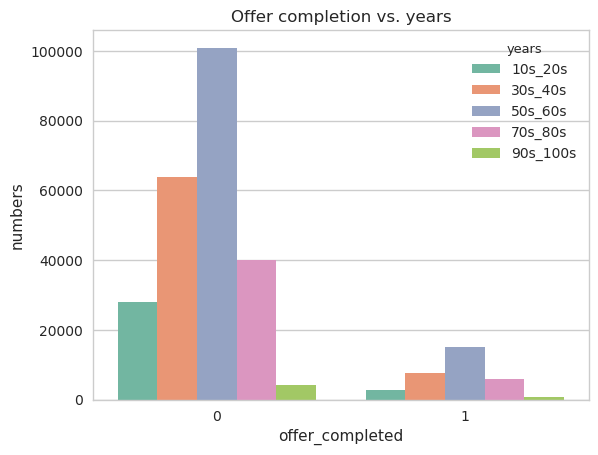

In [134]:
cols=['offer_completed','years']
vasl_gdf(cols,pro_tran)

(   offer_completed  offer_viewed  numbers
 0                0             0   187761
 1                0             1    49087
 2                1             0    31943,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f733b9446d8>)

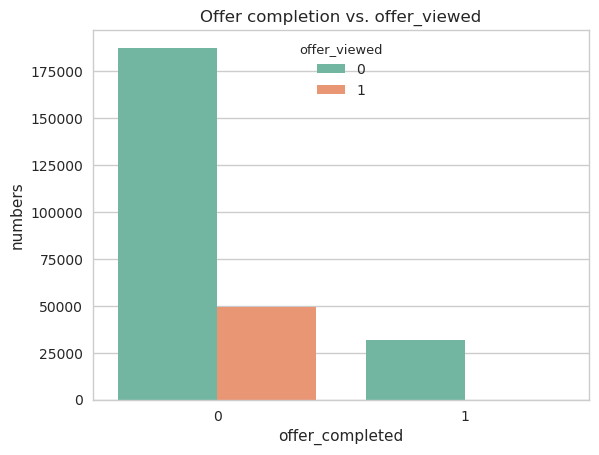

In [135]:
cols=['offer_completed','offer_viewed']
vasl_gdf(cols,pro_tran)

With df.groupby().count() can be used to calculate the number of people under various conditions.

In [126]:
proportra.groupby(['offer_viewed','offer_completed','gender']).count()

customer_id  event   time  types  \
offer_viewed offer_completed gender                                     
0            0               F             27456  27456  27456  27456   
                             M             38129  38129  38129  38129   
             1               F             15477  15477  15477  15477   
                             M             16466  16466  16466  16466   
1            0               F             20786  20786  20786  20786   
                             M             28301  28301  28301  28301   

                                     offer_id  offer_received  transaction  \
offer_viewed offer_completed gender                                          
0            0               F          27456           27456        27456   
                             M          38129           38129        38129   
             1               F          15477           15477        15477   
                             M          16466           16466        16466   
1            0               F          20786           20786        20786   
                             M          28301           28301        28301   

                                       age  became_member_on  income  ...    \
offer_viewed offer_completed gender                                   ...     
0            0               F       27456             27456   27456  ...     
                             M       38129             38129   38129  ...     
             1               F       15477             15477   15477  ...     
                             M       16466             16466   16466  ...     
1            0               F       20786             20786   20786  ...     
                             M       28301             28301   28301  ...     

                                     income_rank  channels  difficulty  \
offer_viewed offer_completed gender                                      
0            0               F             27456     27456       27456   
                             M             38129     38129       38129   
             1               F             15477     15477       15477   
                             M             16466     16466       16466   
1            0               F             20786     20786       20786   
                             M             28301     28301       28301   

                                     duration  offer_type  reward    web  \
offer_viewed offer_completed gender                                        
0            0               F          27456       27456   27456  27456   
                             M          38129       38129   38129  38129   
             1               F          15477       15477   15477  15477   
                             M          16466       16466   16466  16466   
1            0               F          20786       20786   20786  20786   
                             M          28301       28301   28301  28301   

                                     email  mobile  socia  
offer_viewed offer_completed gender                        
0            0               F       27456   27456  27456  
                             M       38129   38129  38129  
             1               F       15477   15477  15477  
                             M       16466   16466  16466  
1            0               F       20786   20786  20786  
                             M       28301   28301  28301  

[6 rows x 23 columns]

From this chart we can see 'There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.' in the introduction.

In [11]:
pro_tran.groupby(['offer_received','offer_viewed','offer_completed','gender']).count()

age  became_days  \
offer_received offer_viewed offer_completed gender                       
0              0            0               F       49382        49382   
                                            M       72794        72794   
                            1               F       15477        15477   
                                            M       16466        16466   
               1            0               F       20786        20786   
                                            M       28301        28301   
1              0            0               F       27456        27456   
                                            M       38129        38129   

                                                    became_member_on  \
offer_received offer_viewed offer_completed gender                     
0              0            0               F                  49382   
                                            M                  72794   
                            1               F                  15477   
                                            M                  16466   
               1            0               F                  20786   
                                            M                  28301   
1              0            0               F                  27456   
                                            M                  38129   

                                                    became_onyear  \
offer_received offer_viewed offer_completed gender                  
0              0            0               F               49382   
                                            M               72794   
                            1               F               15477   
                                            M               16466   
               1            0               F               20786   
                                            M               28301   
1              0            0               F               27456   
                                            M               38129   

                                                    customer_id  event  \
offer_received offer_viewed offer_completed gender                       
0              0            0               F             49382  49382   
                                            M             72794  72794   
                            1               F             15477  15477   
                                            M             16466  16466   
               1            0               F             20786  20786   
                                            M             28301  28301   
1              0            0               F             27456  27456   
                                            M             38129  38129   

                                                    income  income_rank  \
offer_received offer_viewed offer_completed gender                        
0              0            0               F        49382        49382   
                                            M        72794        72794   
                            1               F        15477        15477   
                                            M        16466        16466   
               1            0               F        20786        20786   
                                            M        28301        28301   
1              0            0               F        27456        27456   
                                            M        38129        38129   

                                                    offer_id   time  \
offer_received offer_viewed offer_completed gender                    
0              0            0               F          49382  49382   
                                            M          72794  72794   
                            1               F          15477  15477   
                                            M         

In [127]:
proportra.groupby(['offer_received','offer_viewed','offer_completed','gender']).count()

customer_id  event   time  \
offer_received offer_viewed offer_completed gender                              
0              0            1               F             15477  15477  15477   
                                            M             16466  16466  16466   
               1            0               F             20786  20786  20786   
                                            M             28301  28301  28301   
1              0            0               F             27456  27456  27456   
                                            M             38129  38129  38129   

                                                    types  offer_id  \
offer_received offer_viewed offer_completed gender                    
0              0            1               F       15477     15477   
                                            M       16466     16466   
               1            0               F       20786     20786   
                                            M       28301     28301   
1              0            0               F       27456     27456   
                                            M       38129     38129   

                                                    transaction    age  \
offer_received offer_viewed offer_completed gender                       
0              0            1               F             15477  15477   
                                            M             16466  16466   
               1            0               F             20786  20786   
                                            M             28301  28301   
1              0            0               F             27456  27456   
                                            M             38129  38129   

                                                    became_member_on  income  \
offer_received offer_viewed offer_completed gender                             
0              0            1               F                  15477   15477   
                                            M                  16466   16466   
               1            0               F                  20786   20786   
                                            M                  28301   28301   
1              0            0               F                  27456   27456   
                                            M                  38129   38129   

                                                    years  ...    income_rank  \
offer_received offer_viewed offer_completed gender         ...                  
0              0            1               F       15477  ...          15477   
                                            M       16466  ...          16466   
               1            0               F       20786  ...          20786   
                                            M       28301  ...          28301   
1              0            0               F       27456  ...          27456   
                                            M       38129  ...          38129   

                                                    channels  difficulty  \
offer_received offer_viewed offer_completed gender                         
0              0            1               F          15477       15477   
                                            M          16466       16466   
               1            0               F          20786       20786   
                                            M          28301       28301   
1              0            0               F          27456       27456   
                                            M          38129       38129   

                                                    duration  offer_type  \
offer_received offer_viewed offer_completed gender                         
0              0            1               F          15477       15477   
                                            M          16466       16466   
               1            0         

In [139]:
pro_tran.offer_viewed.value_counts()

0    219704
1     49087
Name: offer_viewed, dtype: int64

In [137]:
pro_tran.types = pro_tran.types.replace('offer id','offer_id')

In [138]:
pro_tran.types.value_counts()

offer_id    146615
amount      122176
Name: types, dtype: int64

In [140]:
# number of customers
pro_tran.customer_id.nunique()

14613

## To do list:

I'm going to build a model that predicts whether or not someone will respond to an offer. 

- prepare data for modeling
- one hot coding:income_rank,gender,event,years,offer_type,duration
- create new dataframe ppt_dfmerge which merge pro_tran and new_portf (Use only comprehensive data with information)
- normalize age, became_days, income, time, difficulty, duration, reward
- drop unnecessary columns
- save to /data


In [143]:
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,socia
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


In [151]:
len(pro_tran.columns)

24

In [150]:
pro_tran.head(2)

,customer_id,event,time,types,offer_id,offer_received,offer_viewed,transaction,offer_completed,age,...,became_days,became_onyear,income_rank,F,M,70s_80s,50s_60s,90s_100s,30s_40s,10s_20s
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,75,...,767,2017,90~110k,1,0,1,0,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,75,...,767,2017,90~110k,1,0,1,0,0,0,0


In [146]:
# one hot coding gender
for i in ['F', 'M']:
    pro_tran[i] = pro_tran.gender.apply(lambda x: 1 if i in x else 0)

In [149]:
# one hot coding years gradea
for i in ['70s_80s', '50s_60s', '90s_100s', '30s_40s', '10s_20s']:
    pro_tran[i] = pro_tran.years.apply(lambda x: 1 if i in x else 0)

In [155]:
# one hot coding offer type
for i in ['discount','bogo','informational']:
    portfolio[i] = portfolio.offer_type.apply(lambda x: 1 if i in x else 0)
    
new_portf = portfolio[['difficulty', 'duration', 'email', 'mobile', 'offer_id',
                       'reward', 'socia', 'web', 'discount', 'bogo',
                       'informational']]

In [154]:
portfolio.columns

Index(['channels', 'difficulty', 'duration', 'offer_id', 'offer_type',
       'reward', 'web', 'email', 'mobile', 'socia'],
      dtype='object')

In [156]:
ppt_df = pro_tran.merge(new_portf,on='offer_id')

In [158]:
ppt_df.shape

(146615, 34)

In [160]:
ppt_df.years.value_counts()

50s_60s     65673
30s_40s     37495
70s_80s     26149
10s_20s     14576
90s_100s     2722
Name: years, dtype: int64

In [159]:
ppt_df.head()

,customer_id,event,time,types,offer_id,offer_received,offer_viewed,transaction,offer_completed,age,...,difficulty,duration,email,mobile,reward,socia,web,discount,bogo,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,75,...,5,7,1,1,5,0,1,0,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,75,...,5,7,1,1,5,0,1,0,1,0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,0,1,75,...,5,7,1,1,5,0,1,0,1,0
3,e2127556f4f64592b11af22de27a7932,offer received,408,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,68,...,5,7,1,1,5,0,1,0,1,0
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,68,...,5,7,1,1,5,0,1,0,1,0


In [165]:
# Save to csv
ppt_df.to_csv('data/ppt_df.csv')

In [161]:
ppt_df.columns

Index(['customer_id', 'event', 'time', 'types', 'offer_id', 'offer_received',
       'offer_viewed', 'transaction', 'offer_completed', 'age',
       'became_member_on', 'gender', 'income', 'years', 'became_days',
       'became_onyear', 'income_rank', 'F', 'M', '70s_80s', '50s_60s',
       '90s_100s', '30s_40s', '10s_20s', 'difficulty', 'duration', 'email',
       'mobile', 'reward', 'socia', 'web', 'discount', 'bogo',
       'informational'],
      dtype='object')

In [163]:
ppt_df.describe()

,time,offer_received,offer_viewed,transaction,offer_completed,age,became_member_on,income,became_days,became_onyear,...,difficulty,duration,email,mobile,reward,socia,web,discount,bogo,informational
count,146615.000000,146615.000000,146615.000000,146615.0,146615.00000,146615.000000,1.466150e+05,146615.000000,146615.000000,146615.000000,...,146615.000000,146615.000000,146615.0,146615.000000,146615.000000,146615.0,146615.000000,146615.000000,146615.000000,146615.000000
mean,354.699096,0.447328,0.334802,0.0,0.21787,54.774375,2.016643e+07,66444.074617,862.834799,2016.574252,...,7.890441,6.624656,1.0,0.917396,4.444538,0.0,0.806759,0.418723,0.429151,0.152126
std,198.289655,0.497220,0.471923,0.0,0.41280,17.214147,1.177888e+04,21532.620014,415.878676,1.187416,...,5.037013,2.132785,0.0,0.275284,3.373740,0.0,0.394842,0.493351,0.494957,0.359145
min,0.000000,0.000000,0.000000,0.0,0.00000,18.000000,2.013073e+07,30000.000000,324.000000,2013.000000,...,0.000000,3.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,168.000000,0.000000,0.000000,0.0,0.00000,43.000000,2.016043e+07,51000.000000,545.000000,2016.000000,...,5.000000,5.000000,1.0,1.000000,2.000000,0.0,1.000000,0.000000,0.000000,0.000000
50%,408.000000,0.000000,0.000000,0.0,0.00000,56.000000,2.017063e+07,65000.000000,719.000000,2017.000000,...,10.000000,7.000000,1.0,1.000000,5.000000,0.0,1.000000,0.000000,0.000000,0.000000
75%,510.000000,1.000000,1.000000,0.0,0.00000,67.000000,2.017122e+07,81000.000000,1141.000000,2017.000000,...,10.000000,7.000000,1.0,1.000000,5.000000,0.0,1.000000,1.000000,1.000000,0.000000
max,714.000000,1.000000,1.000000,0.0,1.00000,101.000000,2.018073e+07,120000.000000,2147.000000,2018.000000,...,20.000000,10.000000,1.0,1.000000,10.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [162]:
# collect columns for modeling
modppt = ppt_df.drop(['offer_received','event','became_member_on','gender',
                      'became_onyear','income_rank','types','years','offer_id','transaction'],axis=1)

In [166]:
modppt.columns

Index(['customer_id', 'time', 'offer_viewed', 'offer_completed', 'age',
       'income', 'became_days', 'F', 'M', '70s_80s', '50s_60s', '90s_100s',
       '30s_40s', '10s_20s', 'difficulty', 'duration', 'email', 'mobile',
       'reward', 'socia', 'web', 'discount', 'bogo', 'informational'],
      dtype='object')

In [164]:
len(modppt.columns)


24

In [197]:
# change type to int
for i in ['offer_completed', 'offer_viewed', 'email', 'mobile', 'socia', 'web','discount', 'bogo', 'informational','F', 'M',
          '70s_80s', '50s_60s', '90s_100s', '30s_40s', '10s_20s']:
    modppt[i] = modppt[i].astype('int')

In [168]:
# normaliza columns
df_numerc = modppt[['age','became_days','income','time','difficulty','duration','reward']]
scaler = MinMaxScaler()
modppt[['age','became_days','income','time','difficulty','duration','reward']] = scaler.fit_transform(df_numerc) 

In [198]:
modppt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146615 entries, 0 to 146614
Data columns (total 22 columns):
time               146615 non-null float64
offer_viewed       146615 non-null int64
offer_completed    146615 non-null int64
income             146615 non-null float64
became_days        146615 non-null float64
F                  146615 non-null int64
M                  146615 non-null int64
70s_80s            146615 non-null int64
50s_60s            146615 non-null int64
90s_100s           146615 non-null int64
30s_40s            146615 non-null int64
10s_20s            146615 non-null int64
difficulty         146615 non-null float64
duration           146615 non-null float64
email              146615 non-null int64
mobile             146615 non-null int64
reward             146615 non-null float64
socia              146615 non-null int64
web                146615 non-null int64
discount           146615 non-null int64
bogo               146615 non-null int64
informational   

In [8]:
# save to csv
modppt.to_csv('data/modppt.csv',index=False)

## Modeling

### To do list:

- read data from modppt.csv
- break data set into 3 parts 
- set x, y
- make pipeline to features selection, training, prediction, record time, and scoring, cross valuation.
- save accuracy, f1 score, cost time to each dictionary.
- Visualize results
- make comment

In [3]:
modppt = pd.read_csv('data/modppt.csv')

In [4]:
X = modppt.drop(['offer_completed','age','customer_id','Unnamed: 0'],axis=1)
y = modppt['offer_completed']

In [5]:
print(len(modppt),modppt.shape[0]/3)
print(48872+48872)

146615 48871.666666666664
97744


In [6]:
len(modppt.columns)

25

In [7]:
modppt.columns

Index(['Unnamed: 0', 'age', 'became_days', 'customer_id', 'income',
       'offer_completed', 'offer_viewed', 'time', 'F', 'M', '70s_80s',
       '50s_60s', '90s_100s', '30s_40s', '10s_20s', 'difficulty', 'duration',
       'email', 'mobile', 'reward', 'socia', 'web', 'discount', 'bogo',
       'informational'],
      dtype='object')

In [8]:
modppt = modppt.drop(['age','customer_id'],axis=1)
dfa = modppt[:48872]
dfb = modppt[48872:97744]
dfc = modppt[97744:]

modf = [dfa, dfb, dfc]

In [9]:
len(dfc)

48871

Here we use selectkbest to do feature selection, so that to know about the influence for completion. And 3 clusters to train data, they are SVC, RandomforestClassifier, AdaboostClassifier.

In [10]:
selector = SelectKBest(k=5)

def make_pipeline(selector, clf, param_grid, x, y):
    pipe = Pipeline([
        ('fea_sel',selector),
        ('clf',clf)
    ])
    
    start = time.time()
    
    grid = GridSearchCV(pipe,cv=3,param_grid=param_grid)
    grid.fit(x, y)
    y_preds = grid.predict(x)
    f1score = f1_score(y_preds, y)
    accura = accuracy_score(y_preds, y)
    
    end = time.time()
    cost = end - start
    
    return pipe, grid, y_preds, f1score, accura, cost

In [11]:
acc = []
f1 = []
total_time = 0
svcdict = {}
for df in modf:
    x = df.drop(['offer_completed'],axis=1)
    y = df['offer_completed']
    clf = SVC(random_state=18,gamma='auto')
    param_grid = {'clf__C':[0.1, 1, 10,100]}
    
    pipe, grid, y_preds, f1score, accura, cost = make_pipeline(selector, clf, param_grid, x, y)
    total_time += cost
    acc.append(accura)
    f1.append(f1score)
    print(accura,f1score)
    print(cost)

svcdict.update({"accuracy":np.mean(acc),
               "f1_score":np.mean(f1),
               "total_time": total_time})

print(total_time)

/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 15 17 19] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 15 17 19] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 15 17 19] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3

0.810341299722 0.0
452.74704480171204


/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 15 17 18] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 15 17 18] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 15 17 18 20] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/pyth

0.786483057784 0.0
579.4490506649017


/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 17 18 21] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 17 18 21] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 17 18 21] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3

0.776615989032 0.24203290981
1975.4055180549622
3007.601613521576


In [12]:
svcdict

{'accuracy': 0.79114678217922352,
 'f1_score': 0.08067763660348537,
 'total_time': 3007.601613521576}

In [15]:
acc = []
f1 = []
total_time = 0
rfcdict = {}
for df in modf:
    x = df.drop(['offer_completed'],axis=1)
    y = df['offer_completed']
    clfrfc = RandomForestClassifier(random_state=18)
    param_grid = {'clf__max_depth':[2,6,12]}

    pipe, grid, y_preds, f1score, accura,cost = make_pipeline(selector, clfrfc, param_grid, x, y)
    total_time += cost
    acc.append(accura)
    f1.append(f1score)
    print(accura,f1score)
    print(cost)
    
rfcdict.update({"accuracy":np.mean(acc),
               "f1_score":np.mean(f1),
               "total_time": total_time})

print(total_time)

/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 15 17 19] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 15 17 19] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 15 17 19] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3

0.810341299722 0.0
1.27378511428833


/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 15 17 18] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 15 17 18 20] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 15 17 18] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/pyth

0.786483057784 0.0
1.572516679763794


/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 17 18 21] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 17 18 21] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 17 18 21] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3

0.90581326349 0.768402515723
2.4852659702301025
5.331567764282227


In [16]:
rfcdict

{'accuracy': 0.83421254033163839,
 'f1_score': 0.25613417190775684,
 'total_time': 5.331567764282227}

In [57]:
acc = []
f1 = []
rfcdict = {}
for df in modf:
    x = df.drop(['offer_completed'],axis=1)
    y = df['offer_completed']
    clfrfc = RandomForestClassifier(random_state=18)
    param_grid = {'clf__max_depth':[2,6,12]}

    pipe, grid, y_preds, f1score, accura,cost = make_pipeline(selector, clfrfc, param_grid, x, y)
    total_time += cost
    acc.append(accura)
    f1.append(f1score)
    print(accura,f1score)
    print(cost)
    
rfcdict.update({"accuracy":np.mean(acc),
               "f1_score":np.mean(f1),
               "total_time": total_time})

print(total_time)

/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [13 14 16 18] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [13 14 16 18] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [13 14 16 18] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3

0.810341299722 0.0
1.3070240020751953


/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [13 14 16 17] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [13 14 16 17 19] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [13 14 16 17] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/pyth

0.786483057784 0.0
1.5398404598236084


/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [13 16 17 20] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [13 16 17 20] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [13 16 17 20] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3

0.90581326349 0.768402515723
2.1370391845703125
4.983903646469116


In [58]:
rfcdict

{'accuracy': 0.83421254033163839,
 'f1_score': 0.25613417190775684,
 'total_time': 4.983903646469116}

In [17]:
abcdist = {}
acc = []
f1 = []
total_time = 0
for df in modf:
    x = df.drop(['offer_completed'],axis=1)
    y = df['offer_completed']
    clfada = AdaBoostClassifier(random_state=18)
    param_grid = {'clf__learning_rate':[0.01, 0.1, 1]}
    
    pipe, grid, y_preds, f1score, accura, cost= make_pipeline(selector, clfada, param_grid, x, y)
    total_time += cost
    acc.append(accura)
    f1.append(f1score)
    print(accura,f1score)
    print(cost)
               
abcdist.update({"accuracy":np.mean(acc),
               "f1_score":np.mean(f1),
               "total_time": total_time})

print(total_time)

/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 15 17 19] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 15 17 19] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 15 17 19] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3

0.810341299722 0.0
19.350796222686768


/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 15 17 18] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 15 17 18] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 15 17 18 20] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/pyth

0.786483057784 0.0
20.87768864631653


/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 17 18 21] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 17 18 21] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 17 18 21] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3

0.804608049764 0.3603724295
13.224272727966309
53.452757596969604


In [18]:
abcdist

{'accuracy': 0.80047746908966122,
 'f1_score': 0.12012414316654386,
 'total_time': 53.452757596969604}

Understanding which factors have a great impact on completion

In [19]:
def get_selectf(selector, x, y):
    """
    Input:
    selector: selectkbest
    x: x
    y: y
    
    Output:
    sel_f(list): feature indexs
    x_feated: feature names
    
    """
    sel_f =[]
    fidx = selector.fit(x,y).get_support()
    for i,v in enumerate(fidx):
        if v == True:
            sel_f.append(i)
            
    x_cols = list(x.columns)
    x_feated = []
    for i,v in enumerate(x_cols):
        if i in sel_f:
            x_feated.append(v)
            
    return sel_f, x_feated
    

In [20]:
sel_f, x_feated = get_selectf(selector, x, y)
x_feated

/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14 17 18 21] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


['income', 'offer_viewed', 'time', 'discount', 'bogo']

Knowning that these factors above all play a major role in the correct prediction. Here I will call RandomForestClassifier---RFE, and AdaboostClassifier --- ABC, and SVC.

In [21]:
res = pd.DataFrame(rfcdict,index=['RFC'],columns=['accuracy','f1_score','total_time'])
res1 = pd.DataFrame(svcdict,index=['SVC'],columns=['accuracy','f1_score','total_time'])
res2 = pd.DataFrame(abcdist,index=['ABC'],columns=['accuracy','f1_score','total_time'])
all_result = pd.concat([res,res1,res2],axis=0)
all_result = all_result.reset_index()
all_result.columns = ['clf', 'accuracy', 'f1_score', 'total_time']

In [22]:
all_result

,clf,accuracy,f1_score,total_time
0,RFC,0.834213,0.256134,5.331568
1,SVC,0.791147,0.080678,3007.601614
2,ABC,0.800477,0.120124,53.452758


In [26]:
all_result.to_csv('data/all_result.csv',index=False)

In [8]:
all_result = pd.read_csv('data/all_result.csv')

In [9]:
all_result

,clf,accuracy,f1_score,total_time
0,RFC,0.834213,0.256134,5.331568
1,SVC,0.791147,0.080678,3007.601614
2,ABC,0.800477,0.120124,53.452758


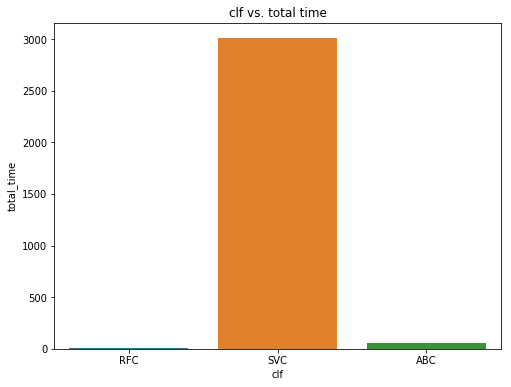

In [11]:
plt.figure(figsize=(8,6))
plt.title('clf vs. total time')
sns.barplot(x='clf', y='total_time',data=all_result);

In [15]:
all_result

,clf,accuracy,f1_score,total_time
0,RFC,0.834213,0.256134,5.331568
1,SVC,0.791147,0.080678,3007.601614
2,ABC,0.800477,0.120124,53.452758


In [18]:
allt = all_result.T
alltr = allt[[0]][1:3]
allts = allt[[1]][1:3]
allta = allt[[2]][1:3]

In [20]:
alltr['clf'] = "RFE"
allts['clf'] = "SVC"
allta['clf'] = "ABC"

alltr.columns = ['val','clf']
allts.columns = ['val','clf']
allta.columns = ['val','clf']

alld = pd.concat([alltr,allts,allta],axis=0)
alld = alld.reset_index()
alld.columns = ['eva', 'val', 'clf']

In [21]:
alld

,eva,val,clf
0,accuracy,0.834213,RFE
1,f1_score,0.256134,RFE
2,accuracy,0.791147,SVC
3,f1_score,0.0806776,SVC
4,accuracy,0.800477,ABC
5,f1_score,0.120124,ABC


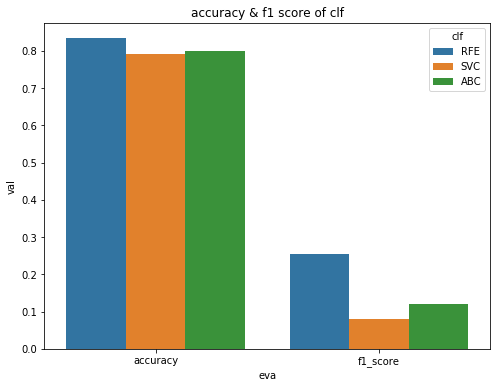

In [22]:
plt.figure(figsize=(8,6))
plt.title('accuracy & f1 score of clf')
sns.barplot(x='eva',y='val',hue='clf',data=alld);

## Comment：

In this data set, we know that the accuracy of RFE is the highest by comparing the charts, and the other two are not very different. Then compare the time spent on training data. From the figure above, we can see that the longest time spent on SVC is more than 3000s, the other two are relatively faster, RFE is the fastest, followed by ABC. Considering the above results, SVC is not a good choice. The time spent on SVC does not bring higher accuracy. Then the best one is rfe, and the shortest one is rfe. Although ABC is fast, it is still inferior to RFE in all aspects. So in the end, I think RFE is the best choice under this data set.